## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import lightgbm as lgbm
import catboost as cb
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import OrderedDict

RSTATE = 13112020
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv(r'datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    try:
        df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    except:
        print('Ошибка подгрузки данных')

Ознакомимся с данными

In [3]:
df.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим данные на монотонность.

In [5]:
df.index.is_monotonic

True

In [6]:
df = df.resample('1H').sum()

In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Оценим пропуски.

In [8]:
df.isna().sum()

num_orders    0
dtype: int64

# 2. Анализ

Попробуем найти тренды.

In [9]:
decomposed = seasonal_decompose(df)

Посмотрим на скользящее среднее.

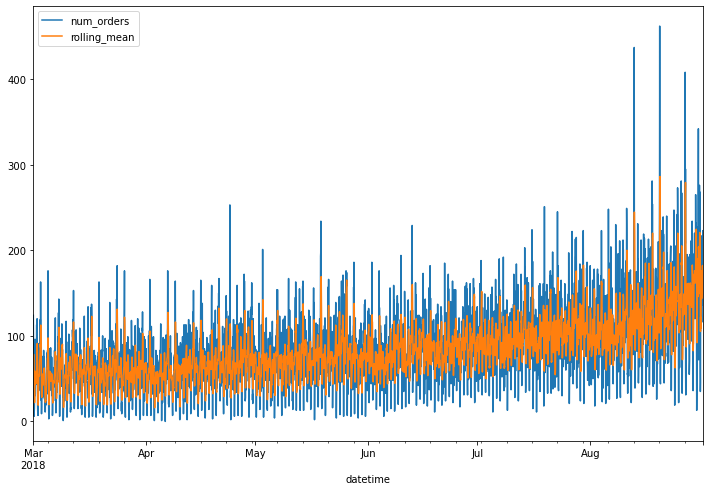

In [10]:
df['rolling_mean'] = df.rolling(5).mean()
df.plot(figsize=(12,8))

Видно, что количество вызовов такси в час растет со временем.

Посмотрим на тренд, сезонность и остатки.

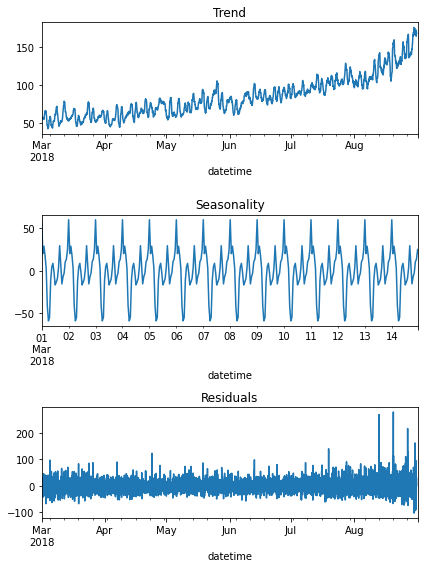

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд на увеличение вызовов в час.

Удалим столбец `rolling_mean`, добавим его позже через функцию.

In [12]:
df.drop('rolling_mean', inplace=True, axis=1)

# 3. Обучение

Создадим признаки функцией `make_features`.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [14]:
make_features(df, 24, 24)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


Удалим пропуски (в нашем случае первые сутки)

In [15]:
df.dropna(inplace=True)

Разобьем на выборки.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [17]:
x_train = train.drop('num_orders', axis=1)
x_train.shape

(3952, 29)

In [18]:
y_train = train['num_orders']
y_train.shape

(3952,)

In [19]:
x_test = test.drop('num_orders', axis=1)
x_test.shape

(440, 29)

In [20]:
y_test = test['num_orders']
y_test.shape

(440,)

Данные подготовлены для обучения.

## Линейная регрессия

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

## Случайный лес

In [22]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

## LightGBM

In [23]:
train_data = lgbm.Dataset(x_train, label=y_train)

In [24]:
test_data = lgbm.Dataset(x_test, label=y_test)

При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит используем TimeSeriesSplit.

In [25]:
%%time

tscv = TimeSeriesSplit()
lg = lgbm.LGBMRegressor()
param_dist = {"max_depth": [50, 100],
              "learning_rate" : [0.1, 0.5],
              "num_leaves": [500, 1000],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(x_train, y_train)

Wall time: 9.31 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [50, 100],
                         'n_estimators': [200], 'num_leaves': [500, 1000]},
             scoring='neg_root_mean_squared_error')

In [26]:
grid_search.best_estimator_

LGBMRegressor(max_depth=50, n_estimators=200, num_leaves=500)

In [27]:
print('RMSE =', abs(grid_search.best_score_))

RMSE = 25.921821211611025


In [28]:
%%time
best_parameters = grid_search.best_params_
lg_best = lgbm.train(best_parameters, train_data)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4853
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 28
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## CatBoost

In [29]:
%%time
cb = CatBoostRegressor()
cb.fit(x_train, y_train)

Learning rate set to 0.049846
0:	learn: 37.8261676	total: 58.4ms	remaining: 58.3s
1:	learn: 37.0088026	total: 62ms	remaining: 31s
2:	learn: 36.2604487	total: 65.2ms	remaining: 21.7s
3:	learn: 35.5483868	total: 68.6ms	remaining: 17.1s
4:	learn: 34.9024710	total: 71.8ms	remaining: 14.3s
5:	learn: 34.2885073	total: 74.8ms	remaining: 12.4s
6:	learn: 33.7077331	total: 77.5ms	remaining: 11s
7:	learn: 33.1125495	total: 80.4ms	remaining: 9.97s
8:	learn: 32.6365674	total: 83.5ms	remaining: 9.2s
9:	learn: 32.1277246	total: 86.2ms	remaining: 8.53s
10:	learn: 31.6253494	total: 89.1ms	remaining: 8.01s
11:	learn: 31.1710889	total: 91.9ms	remaining: 7.57s
12:	learn: 30.7336277	total: 95.1ms	remaining: 7.22s
13:	learn: 30.4002586	total: 98.1ms	remaining: 6.91s
14:	learn: 30.0278836	total: 101ms	remaining: 6.63s
15:	learn: 29.6855997	total: 104ms	remaining: 6.38s
16:	learn: 29.3613752	total: 106ms	remaining: 6.15s
17:	learn: 29.0447474	total: 109ms	remaining: 5.97s
18:	learn: 28.7685730	total: 112ms	re

161:	learn: 21.0577502	total: 529ms	remaining: 2.74s
162:	learn: 21.0427561	total: 532ms	remaining: 2.73s
163:	learn: 21.0210736	total: 535ms	remaining: 2.73s
164:	learn: 20.9883578	total: 538ms	remaining: 2.72s
165:	learn: 20.9724206	total: 541ms	remaining: 2.72s
166:	learn: 20.9382614	total: 544ms	remaining: 2.71s
167:	learn: 20.9211126	total: 547ms	remaining: 2.71s
168:	learn: 20.8879346	total: 550ms	remaining: 2.7s
169:	learn: 20.8712046	total: 552ms	remaining: 2.7s
170:	learn: 20.8421027	total: 555ms	remaining: 2.69s
171:	learn: 20.8157180	total: 558ms	remaining: 2.69s
172:	learn: 20.7916064	total: 561ms	remaining: 2.68s
173:	learn: 20.7632455	total: 564ms	remaining: 2.68s
174:	learn: 20.7361505	total: 567ms	remaining: 2.67s
175:	learn: 20.7333433	total: 569ms	remaining: 2.67s
176:	learn: 20.7085820	total: 572ms	remaining: 2.66s
177:	learn: 20.6829707	total: 575ms	remaining: 2.65s
178:	learn: 20.6802900	total: 578ms	remaining: 2.65s
179:	learn: 20.6691850	total: 580ms	remaining: 2

333:	learn: 17.8748220	total: 1.02s	remaining: 2.03s
334:	learn: 17.8585184	total: 1.02s	remaining: 2.03s
335:	learn: 17.8509830	total: 1.02s	remaining: 2.03s
336:	learn: 17.8499369	total: 1.03s	remaining: 2.02s
337:	learn: 17.8489205	total: 1.03s	remaining: 2.02s
338:	learn: 17.8479307	total: 1.03s	remaining: 2.02s
339:	learn: 17.8466384	total: 1.04s	remaining: 2.01s
340:	learn: 17.8310698	total: 1.04s	remaining: 2.01s
341:	learn: 17.8168914	total: 1.04s	remaining: 2s
342:	learn: 17.7955913	total: 1.04s	remaining: 2s
343:	learn: 17.7860450	total: 1.05s	remaining: 2s
344:	learn: 17.7631304	total: 1.05s	remaining: 1.99s
345:	learn: 17.7476670	total: 1.05s	remaining: 1.99s
346:	learn: 17.7310447	total: 1.05s	remaining: 1.99s
347:	learn: 17.7218878	total: 1.06s	remaining: 1.98s
348:	learn: 17.7175730	total: 1.06s	remaining: 1.98s
349:	learn: 17.7167264	total: 1.06s	remaining: 1.98s
350:	learn: 17.6904304	total: 1.07s	remaining: 1.97s
351:	learn: 17.6796898	total: 1.07s	remaining: 1.97s
35

519:	learn: 15.3897409	total: 1.54s	remaining: 1.42s
520:	learn: 15.3808809	total: 1.55s	remaining: 1.42s
521:	learn: 15.3632513	total: 1.55s	remaining: 1.42s
522:	learn: 15.3535777	total: 1.55s	remaining: 1.42s
523:	learn: 15.3482659	total: 1.55s	remaining: 1.41s
524:	learn: 15.3267434	total: 1.56s	remaining: 1.41s
525:	learn: 15.3179444	total: 1.56s	remaining: 1.41s
526:	learn: 15.3048657	total: 1.56s	remaining: 1.4s
527:	learn: 15.2934848	total: 1.56s	remaining: 1.4s
528:	learn: 15.2844888	total: 1.57s	remaining: 1.4s
529:	learn: 15.2742993	total: 1.57s	remaining: 1.39s
530:	learn: 15.2654991	total: 1.57s	remaining: 1.39s
531:	learn: 15.2498769	total: 1.58s	remaining: 1.39s
532:	learn: 15.2428759	total: 1.58s	remaining: 1.38s
533:	learn: 15.2272514	total: 1.58s	remaining: 1.38s
534:	learn: 15.2066993	total: 1.58s	remaining: 1.38s
535:	learn: 15.1949764	total: 1.59s	remaining: 1.37s
536:	learn: 15.1812468	total: 1.59s	remaining: 1.37s
537:	learn: 15.1671538	total: 1.59s	remaining: 1.

690:	learn: 13.7222254	total: 2.06s	remaining: 924ms
691:	learn: 13.7156103	total: 2.07s	remaining: 921ms
692:	learn: 13.7056939	total: 2.07s	remaining: 918ms
693:	learn: 13.6954555	total: 2.07s	remaining: 915ms
694:	learn: 13.6894494	total: 2.08s	remaining: 912ms
695:	learn: 13.6790658	total: 2.08s	remaining: 909ms
696:	learn: 13.6664755	total: 2.08s	remaining: 906ms
697:	learn: 13.6588133	total: 2.09s	remaining: 903ms
698:	learn: 13.6464365	total: 2.09s	remaining: 900ms
699:	learn: 13.6343421	total: 2.09s	remaining: 897ms
700:	learn: 13.6283280	total: 2.1s	remaining: 894ms
701:	learn: 13.6249506	total: 2.1s	remaining: 891ms
702:	learn: 13.6221288	total: 2.1s	remaining: 888ms
703:	learn: 13.6123596	total: 2.1s	remaining: 885ms
704:	learn: 13.5989085	total: 2.11s	remaining: 882ms
705:	learn: 13.5887742	total: 2.11s	remaining: 879ms
706:	learn: 13.5854014	total: 2.11s	remaining: 876ms
707:	learn: 13.5850168	total: 2.12s	remaining: 873ms
708:	learn: 13.5777409	total: 2.12s	remaining: 870

869:	learn: 12.4039158	total: 2.59s	remaining: 387ms
870:	learn: 12.3970248	total: 2.59s	remaining: 384ms
871:	learn: 12.3956587	total: 2.6s	remaining: 381ms
872:	learn: 12.3878072	total: 2.6s	remaining: 378ms
873:	learn: 12.3745008	total: 2.6s	remaining: 375ms
874:	learn: 12.3626386	total: 2.6s	remaining: 372ms
875:	learn: 12.3622846	total: 2.61s	remaining: 369ms
876:	learn: 12.3511082	total: 2.61s	remaining: 366ms
877:	learn: 12.3481789	total: 2.61s	remaining: 363ms
878:	learn: 12.3428550	total: 2.62s	remaining: 360ms
879:	learn: 12.3340942	total: 2.62s	remaining: 357ms
880:	learn: 12.3234332	total: 2.62s	remaining: 354ms
881:	learn: 12.3211911	total: 2.63s	remaining: 351ms
882:	learn: 12.3193914	total: 2.63s	remaining: 348ms
883:	learn: 12.3102865	total: 2.63s	remaining: 345ms
884:	learn: 12.3029201	total: 2.63s	remaining: 342ms
885:	learn: 12.2866689	total: 2.64s	remaining: 339ms
886:	learn: 12.2857900	total: 2.64s	remaining: 336ms
887:	learn: 12.2752943	total: 2.64s	remaining: 333

# 4. Тестирование

Оценим среднее квадратичное отклонение разных моделей.

In [30]:
predict = lin_reg.predict(x_test)
rmse_lin_reg = mean_squared_error(y_test, predict) ** 0.5
print('RMSE =', rmse_lin_reg)

RMSE = 45.54244745506208


In [31]:
predict = rf.predict(x_test)
rmse_rf = mean_squared_error(y_test, predict) ** 0.5
print('RMSE =', rmse_rf)

RMSE = 43.60866882127493


In [32]:
predict = lg_best.predict(x_test)
rmse_lg = mean_squared_error(y_test, predict) ** 0.5
print('RMSE =', rmse_lg)

RMSE = 43.34893907681592


In [33]:
predict = cb.predict(x_test)
rmse_cb = mean_squared_error(y_test, predict) ** 0.5
print('RMSE =', rmse_cb)

RMSE = 40.63539938906839


Сформируем результаты.

In [34]:
results = {'RMSE': [rmse_lin_reg, rmse_rf, rmse_lg, rmse_cb]}

In [35]:
pd.DataFrame(results, index=['Linear Regression', 'Random Forest', 'LightGBM', 'CatBoost'])

,RMSE
Linear Regression,45.542447
Random Forest,43.608669
LightGBM,43.348939
CatBoost,40.635399


# Вывод

По условию проекта необходимо было спрогнозировать количество заказов такси на следующий час для компании «Чётенькое такси».

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Подгрузили данные, выполнили ресемплирование по часу (было по 10 минут). Выполнили небольшую предобработку, проверили на пропуски, даты подгрузили в формате DateTime64, проверили данные на монотонность - все в порядке.

Далее проверили небольшой анализ данных, с помощью библиотеки `seasonal_decompose` и скользящего среднего нашли тренд - количество заказов увеличивается с течением времени. Также перед обучением создали функцию `male_features`, которая создала признаки для прогнозирования заказов в следующий час. Добавили календарные признаки(год, месяц, день месяца и день недели), "отстающие" значения (lag features) и скользящее среднее.

После этого обучали модели: линейную регрессию, случайный лес, LightGBM и CatBoost. По условию задачи итоговая метрика RMSE не должна была превышать 48. Условие выполнено всеми выбранными моделями: лучший результат показал CatBoost, худший - линейная регрессия.